In [2]:
from IPython.display import HTML, display

def set_css():
    display(HTML('''<style> pre {white-space: pre-wrap;} </style>'''))
get_ipython().events.register('pre_run_cell', set_css)

In [1]:
import pandas as pd 
import numpy as np 
import re 
import os
import time
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.models import Sequential, load_model
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, Bidirectional, GRU
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils

2.4.1
2.4.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# load songs
songs = pd.read_csv('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/data/lana_lyrics_98.csv')

# put lyrics into 1 string
text = ''
for song in songs['lyrics']:
    text = text + song.lower()
    
# remove the text with brackets around them, such as [Verse 1]
text = re.sub(r'\[[^][]*\]', '', text)
text = re.sub(r'\(|\)', '', text)

In [7]:
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

Length of text: 160910 characters
59 unique characters


In [8]:
# taking a look at the first 300 characters
print(text[:300])


why? "got that?"
who, me? "louder!"
why? "got that?"


feet don't fail me now
take me to the finish line
oh, my heart, it breaks every step that i take
but i'm hoping at the gates, they'll tell me that you're mine
walking through the city streets, is it by mistake or design?
i feel so alone on a fr


### 2- Mapping characters :
 Make two dictionaries , one to convert chars to ints , the other to convert ints back to chars : 


In [9]:
# Mapping chars to ints
chars = sorted(list(set(text)))
int_chars = dict((i, c) for i, c in enumerate(chars))
chars_int = dict((i, c) for c, i in enumerate(chars))

In [10]:
# Get number of chars and vocab in our text
n_chars = len(text)
n_vocab = len(chars)

print('Total Characters : ' , n_chars) # number of all the characters in lyricsText.txt
print('Total Vocab : ', n_vocab) # number of unique characters

Total Characters :  160910
Total Vocab :  59


In [11]:
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)
chars_from_ids = preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

In [12]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset_0 = sequences.map(split_input_target)

for input_example, target_example in dataset_0.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'\nwhy? "got that?"\nwho, me? "louder!"\nwhy? "got that?"\n\n\nfeet don\'t fail me now\ntake me to the finish'
Target: b'why? "got that?"\nwho, me? "louder!"\nwhy? "got that?"\n\n\nfeet don\'t fail me now\ntake me to the finish '


In [13]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset_0
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [14]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [15]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(rnn_units,
                       return_sequences=True,
                       return_state=True)
        self.dropout = Dropout(0.1)
        # self.dense_0 = Dense(10, activation='relu')
        self.dense_1 = Dense(vocab_size/2, activation='relu')
        self.dense_2 = Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dropout(x, training=training)
        # x = self.dense_0(x, training=training)
        x = self.dense_1(x, training=training)
        x = self.dense_2(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [22]:
K.clear_session()
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 60) # (batch_size, sequence_length, vocab_size)


In [23]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  15360     
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  30750     
_________________________________________________________________
dense_1 (Dense)              multiple                  1860      
Total params: 3,986,274
Trainable params: 3,986,274
Non-trainable params: 0
_________________________________________________________________


In [24]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics='accuracy')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, callbacks=[early_stopping])

# Save the weights
model.save_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_chars/ldr_by_chars')

Epoch 1/30
24/24 [==============================] - 3s 46ms/step - loss: 4.1898 - accuracy: 0.1476
Epoch 2/30
24/24 [==============================] - 1s 44ms/step - loss: 3.4812 - accuracy: 0.2150
Epoch 3/30
24/24 [==============================] - 1s 44ms/step - loss: 2.6995 - accuracy: 0.2782
Epoch 4/30
24/24 [==============================] - 1s 44ms/step - loss: 2.4500 - accuracy: 0.3057
Epoch 5/30
24/24 [==============================] - 1s 45ms/step - loss: 2.2984 - accuracy: 0.3349
Epoch 6/30
24/24 [==============================] - 1s 44ms/step - loss: 2.1980 - accuracy: 0.3649
Epoch 7/30
24/24 [==============================] - 1s 45ms/step - loss: 2.1031 - accuracy: 0.3848
Epoch 8/30
24/24 [==============================] - 1s 44ms/step - loss: 2.0063 - accuracy: 0.4073
Epoch 9/30
24/24 [==============================] - 1s 45ms/step - loss: 1.9194 - accuracy: 0.4300
Epoch 10/30
24/24 [==============================] - 1s 44ms/step - loss: 1.8372 - accuracy: 0.4546
Epoch 11/

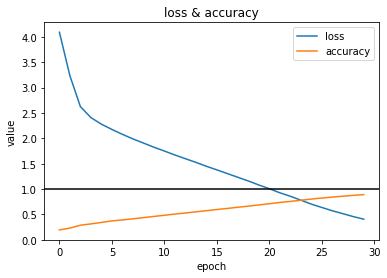

In [25]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.axhline(y=1, color='k')
plt.title('loss & accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [16]:
# Create a new model instance
model_loaded = MyModel(
                    # Be sure the vocabulary size matches the `StringLookup` layers.
                    vocab_size=len(ids_from_chars.get_vocabulary()),
                    embedding_dim=embedding_dim,
                    rnn_units=rnn_units)
model_loaded.load_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_chars/ldr_by_chars')

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model_loaded.compile(loss=loss, optimizer='adam')

In [26]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [27]:
def generate_n_chars(seed, n, model=model_loaded, chars_from_ids=chars_from_ids, ids_from_chars=ids_from_chars, temperature=1.0):
    one_step_model = OneStep(model, chars_from_ids, ids_from_chars, temperature=temperature)
    states = None
    next_char = tf.constant([seed])
    result = [next_char]
    for n in range(n):
        next_char, states = one_step_model.generate_one_step(next_char, states=states)
        result.append(next_char)

    result = tf.strings.join(result)

    return result[0].numpy().decode('utf-8')

In [31]:
predicted = generate_n_chars(seed='you\'re so art deco out on the floor shining like gun metal ', n=500, temperature=1.0)
print(predicted)

you're so art deco out on the floor shining like gun metal where i want
light of my lips, i can be jose fine
baby, we undero if out of our swinlie's girl
how don't keep your crazy for anthem now
save me, but i don't know
you're screwed up toning out changes
hatce bagas tonight, i can see your fecers
leaning out chargen and youn not were done it blue
and while he sed tcarse by why it like a million daman
mmenbind 'cause beautiful people is a been singing
money is the end of tuight uver the endight
babe, baby flees and pasth, helly on hid with how younger


In [29]:
predicted = generate_n_chars(seed='diamonds in the sky', n=500, temperature=1.0)
print(predicted)

diamonds in the sky
summer's in the yabrous yeah
skeat it's been waiting time like a piccun, but you came becking just a same
baby, howe's love nem
not saby"d in feel him this find those birctested oh, baby
i'm on the ohe past
say i should take you for where yako, i know



you velvet me up me to kay
his heart down new ont in the garden
charkan past lown not do sprep that body go
breakbee mine
nown and diabonss
will all that me, i wanna talk
we did it for surnet on the stopped pellstovi
letting in the games, they 
